In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.9 MB/s eta 0:00:00


In [2]:
# Importing Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torcheval.metrics.functional import binary_f1_score

import torch.nn.functional as F

import os
from PIL import Image
import pandas as pd

In [3]:
# Setting Seed
torch.manual_seed(2023)
torch.cuda.manual_seed_all(2023)
torch.cuda.manual_seed(2023)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# Setting device to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import sys
sys.path.append("/kaggle/input/net-and-helper-functions")
from train import trainer

In [6]:
# define data augmentation transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = ImageFolder('/kaggle/input/splitted-ddd/output/train', transform=train_transforms)

In [7]:
train_size = np.int32(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
class resnet (nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 1000),
            nn.ReLU())
        self.fc1= nn.Sequential(
            nn.Linear(1000, 1))
        
    def forward (self, x):
        x = self.resnet(x)
        #print(x.shape)
        x = self.fc(self.flatten(x))
        x = torch.sigmoid(self.fc1(x))
        return x

In [9]:
model = resnet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[Epoch 1, Batch 50] Loss: 0.691 Accuracy: 0.383
[Epoch 1, Batch 100] Loss: 0.679 Accuracy: 0.273
[Epoch 1, Batch 150] Loss: 0.669 Accuracy: 0.492
[Epoch 1, Batch 200] Loss: 0.664 Accuracy: 0.539
[Epoch 1, Batch 250] Loss: 0.648 Accuracy: 0.560
[Epoch 1, Batch 300] Loss: 0.641 Accuracy: 0.572
[Epoch 1, Batch 350] Loss: 0.627 Accuracy: 0.524
[Epoch 1, Batch 400] Loss: 0.627 Accuracy: 0.607
[Epoch 1, Batch 450] Loss: 0.617 Accuracy: 0.597
Epoch 1 Val Loss: 0.5856356337919073 		 Val Accuracy: 0.6502777338027954
Validation Loss Decreased(inf---->0.585636) 	 Saving the Model
[Epoch 2, Batch 50] Loss: 0.582 Accuracy: 0.665
[Epoch 2, Batch 100] Loss: 0.572 Accuracy: 0.660
[Epoch 2, Batch 150] Loss: 0.541 Accuracy: 0.712
[Epoch 2, Batch 200] Loss: 0.553 Accuracy: 0.668
[Epoch 2, Batch 250] Loss: 0.541 Accuracy: 0.718
[Epoch 2, Batch 300] Loss: 0.529 Accuracy: 0.704
[Epoch 2, Batch 350] Loss: 0.531 Accuracy: 0.715
[Epoch 2, Batch 400] Loss: 0.514 Accuracy: 0.728
[Epoch 2, Batch 450] Loss: 0.512 

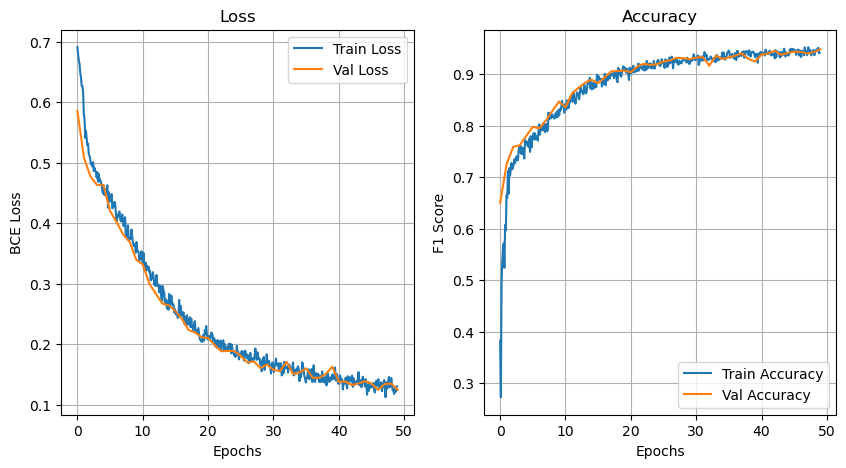

In [10]:
trainer(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, device=device, min_batch_size=50, dest='resnet.pth')